In [1]:
pip install torchvision qwen-vl-utils accelerate transformers pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
print("Installation successful!")

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
Installation successful!


In [1]:
import torch
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor
import os

os.environ["HF_HOME"] = "/n/netscratch/sham_lab/Lab/chloe00/huggingface"
os.environ["TRANSFORMERS_CACHE"] = "/n/netscratch/sham_lab/Lab/chloe00/huggingface"

# Use model name - it will automatically find it in your cache
model_id = "Qwen/Qwen3-VL-8B-Instruct"

print("Loading Qwen3-VL model...")
model = Qwen3VLForConditionalGeneration.from_pretrained(
    model_id,
    dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

processor = AutoProcessor.from_pretrained(
    model_id,
    trust_remote_code=True
)

print("Model loaded successfully!")
print(f"Model type: {type(model)}")

/n/home13/chloe00/miniforge3/envs/vla/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Qwen3-VL model...


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

: 

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Load image
image_path = "/orcd/home/002/yuexing/COLM2026/data/train/fb0046f5396fc4731f4dda322433f18c.jpg"
image = Image.open(image_path)

# Prepare prompt
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "What color is the shoe?"}
        ]
    }
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to(model.device)

# Use forward() instead of generate() to get attentions
print("Running forward pass with attention extraction...")
with torch.no_grad():
    outputs = model(
        **inputs,
        output_attentions=True,
        output_hidden_states=True
    )

# Check what we got
print(f"Output keys: {outputs.keys()}")
print(f"Attentions type: {type(outputs.attentions)}")

if outputs.attentions is not None:
    print(f"Number of layers: {len(outputs.attentions)}")
    print(f"First layer attention shape: {outputs.attentions[0].shape}")
    
    # Get last layer attention
    last_layer_attn = outputs.attentions[-1]
    print(f"Last layer attention shape: {last_layer_attn.shape}")
    # Expected: [batch_size, num_heads, seq_len, seq_len]
    
    # Average across attention heads
    avg_attn = last_layer_attn.mean(dim=1)  # [batch, seq_len, seq_len]
    print(f"Averaged attention shape: {avg_attn.shape}")
    
    # Get attention from last token (the answer)
    last_token_attn = avg_attn[0, -1, :]  # [seq_len]
    print(f"Last token attention shape: {last_token_attn.shape}")
    print(f"Attention values sample: {last_token_attn[:10]}")
else:
    print("Attentions are None - model may not support output_attentions")

Running forward pass with attention extraction...
Output keys: odict_keys(['logits', 'past_key_values', 'rope_deltas', 'hidden_states'])
Attentions type: <class 'NoneType'>
Attentions are None - model may not support output_attentions



Processing: What color is the shoe?


TypeError: 'NoneType' object is not subscriptable

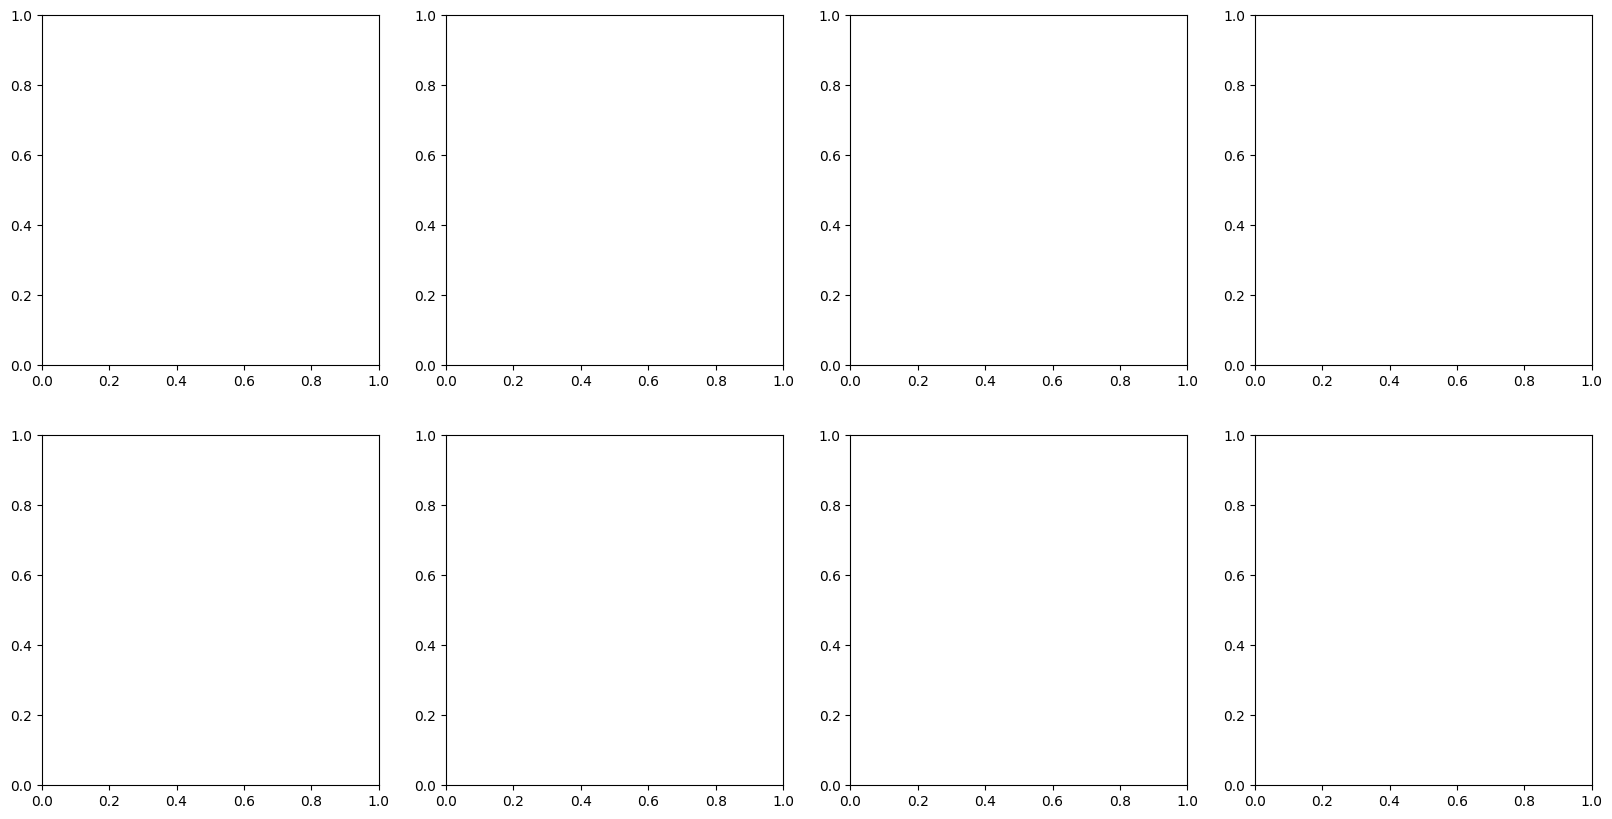

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
from PIL import Image

def compute_gradcam_attention(model, processor, image, question):
    """
    Compute attention using GradCAM - shows where model looks
    """
    # Prepare inputs
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": question}
        ]
    }]
    
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    
    # Move to device and enable gradients
    pixel_values = inputs['pixel_values'].to(model.device).requires_grad_(True)
    input_ids = inputs['input_ids'].to(model.device)
    attention_mask = inputs.get('attention_mask', None)
    if attention_mask is not None:
        attention_mask = attention_mask.to(model.device)
    
    # Forward pass
    outputs = model(
        input_ids=input_ids,
        pixel_values=pixel_values,
        attention_mask=attention_mask
    )
    
    # Get logits and predict
    logits = outputs.logits
    predicted_token = logits[0, -1].argmax()
    
    # Compute gradients
    model.zero_grad()
    score = logits[0, -1, predicted_token]
    score.backward()
    
    # Get gradients on pixel values
    gradients = pixel_values.grad[0]  # [C, H, W]
    
    # Compute importance map
    # Average absolute gradients across channels
    importance_map = gradients.abs().mean(dim=0).cpu().numpy()
    
    # Normalize to [0, 1]
    importance_map = (importance_map - importance_map.min()) / (importance_map.max() - importance_map.min() + 1e-8)
    
    return importance_map

# Use it
image_path = "/orcd/home/002/yuexing/COLM2026/data/train/fb0046f5396fc4731f4dda322433f18c.jpg"
image = Image.open(image_path)

questions = [
    "What color is the shoe?",
    "What color is the pants?",
    "What color is the neckline?",
    "Describe the sleeve."
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, question in enumerate(questions):
    print(f"\nProcessing: {question}")
    
    # Compute attention
    attention_map = compute_gradcam_attention(model, processor, image, question)
    
    # Resize to image size
    scale_h = image.height / attention_map.shape[0]
    scale_w = image.width / attention_map.shape[1]
    attention_resized = zoom(attention_map, (scale_h, scale_w), order=1)
    
    # Original image
    axes[0, i].imshow(image)
    axes[0, i].set_title(f'Q: "{question}"', fontsize=10)
    axes[0, i].axis('off')
    
    # Attention overlay
    axes[1, i].imshow(image)
    axes[1, i].imshow(attention_resized, cmap='jet', alpha=0.6)
    axes[1, i].set_title('Attention Map', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig('attention_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'attention_comparison.png'")

Image size: (733, 1024)
Generating bounding box prediction...

Model output: [362, 222, 452, 567]

Extracted BBox: (362.0, 222.0, 452.0, 567.0)


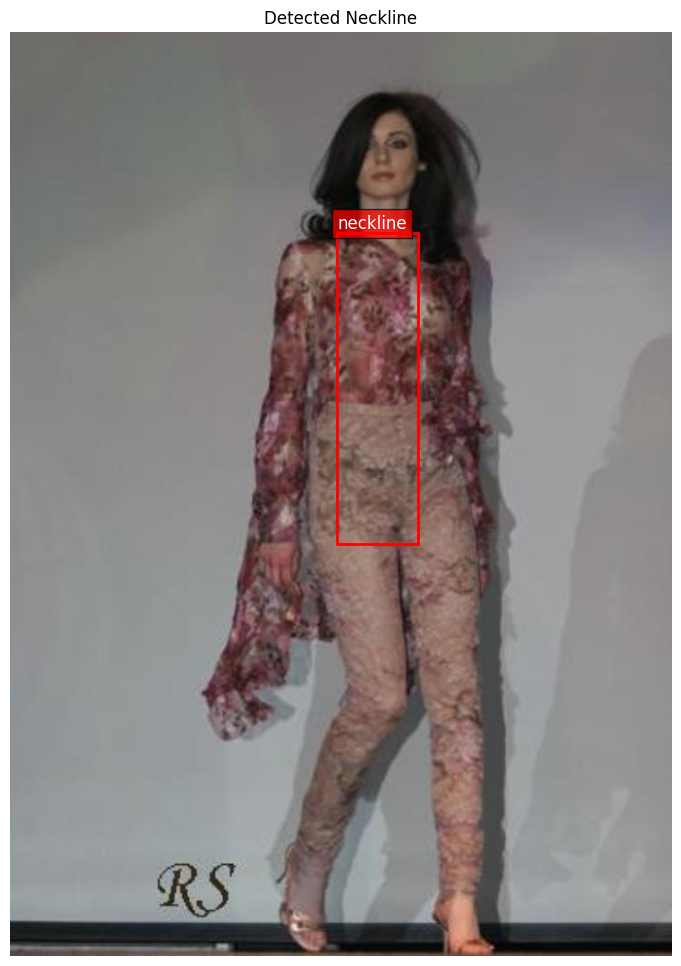

In [7]:
from PIL import Image
import torch

# Load your image
image_path = "/orcd/home/002/yuexing/COLM2026/data/train/06119298104c978ec95233ca0d14815a.jpg"
image = Image.open(image_path)

print(f"Image size: {image.size}")

# Create the prompt asking for pants bounding box
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": "Detect the sleeve in this image and return the bounding box coordinates in the format [x1, y1, x2, y2]. Only return the coordinates, nothing else."
            },
        ],
    }
]

# Prepare for the model
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# Process inputs
inputs = processor(
    text=[text],
    images=[image],
    padding=True,
    return_tensors="pt",
).to(model.device)

# Generate response
print("Generating bounding box prediction...")
with torch.no_grad():
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False
    )

# Decode output
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[0]

print(f"\nModel output: {output_text}")

# Parse the coordinates if they're in the output
import re
coords_match = re.findall(r'\[?\(?([\d.]+),\s*([\d.]+),\s*([\d.]+),\s*([\d.]+)\)?\]?', output_text)
if coords_match:
    x1, y1, x2, y2 = map(float, coords_match[0])
    print(f"\nExtracted BBox: ({x1}, {y1}, {x2}, {y2})")
    
    # Visualize the result
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1, figsize=(10, 12))
    ax.imshow(image)
    
    rect = patches.Rectangle(
        (x1, y1), x2 - x1, y2 - y1,
        linewidth=2, edgecolor='red', facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(x1, y1 - 5, 'neckline', color='white', fontsize=12,
            bbox=dict(facecolor='red', alpha=0.7))
    ax.axis('off')
    plt.title("Detected Neckline")
    plt.show()
else:
    print("Could not parse coordinates from output")

Image size: (733, 1024)
Generating bounding box predictions for multiple items...

Model output:
sleeve: [357, 222, 457, 562]
sleeve: [626, 232, 732, 607]
shoes: [401, 879, 488, 996]
shoes: [636, 935, 732, 998]
neckline: [500, 212, 612, 252]
pants: [416, 397, 718, 935]

Detected sleeve: (357.0, 222.0, 457.0, 562.0)
Detected sleeve: (626.0, 232.0, 732.0, 607.0)
Detected shoes: (401.0, 879.0, 488.0, 996.0)
Detected shoes: (636.0, 935.0, 732.0, 998.0)
Detected neckline: (500.0, 212.0, 612.0, 252.0)
Detected pants: (416.0, 397.0, 718.0, 935.0)

Adjusted Bounding Boxes:
sleeve: (502.5, 232.0, 555.5, 607.0)
shoes: (545.6, 935.0, 622.4, 998.0)
neckline: (416.8, 226.0, 495.2, 258.0)
pants: (356.4, 397.0, 537.6, 935.0)


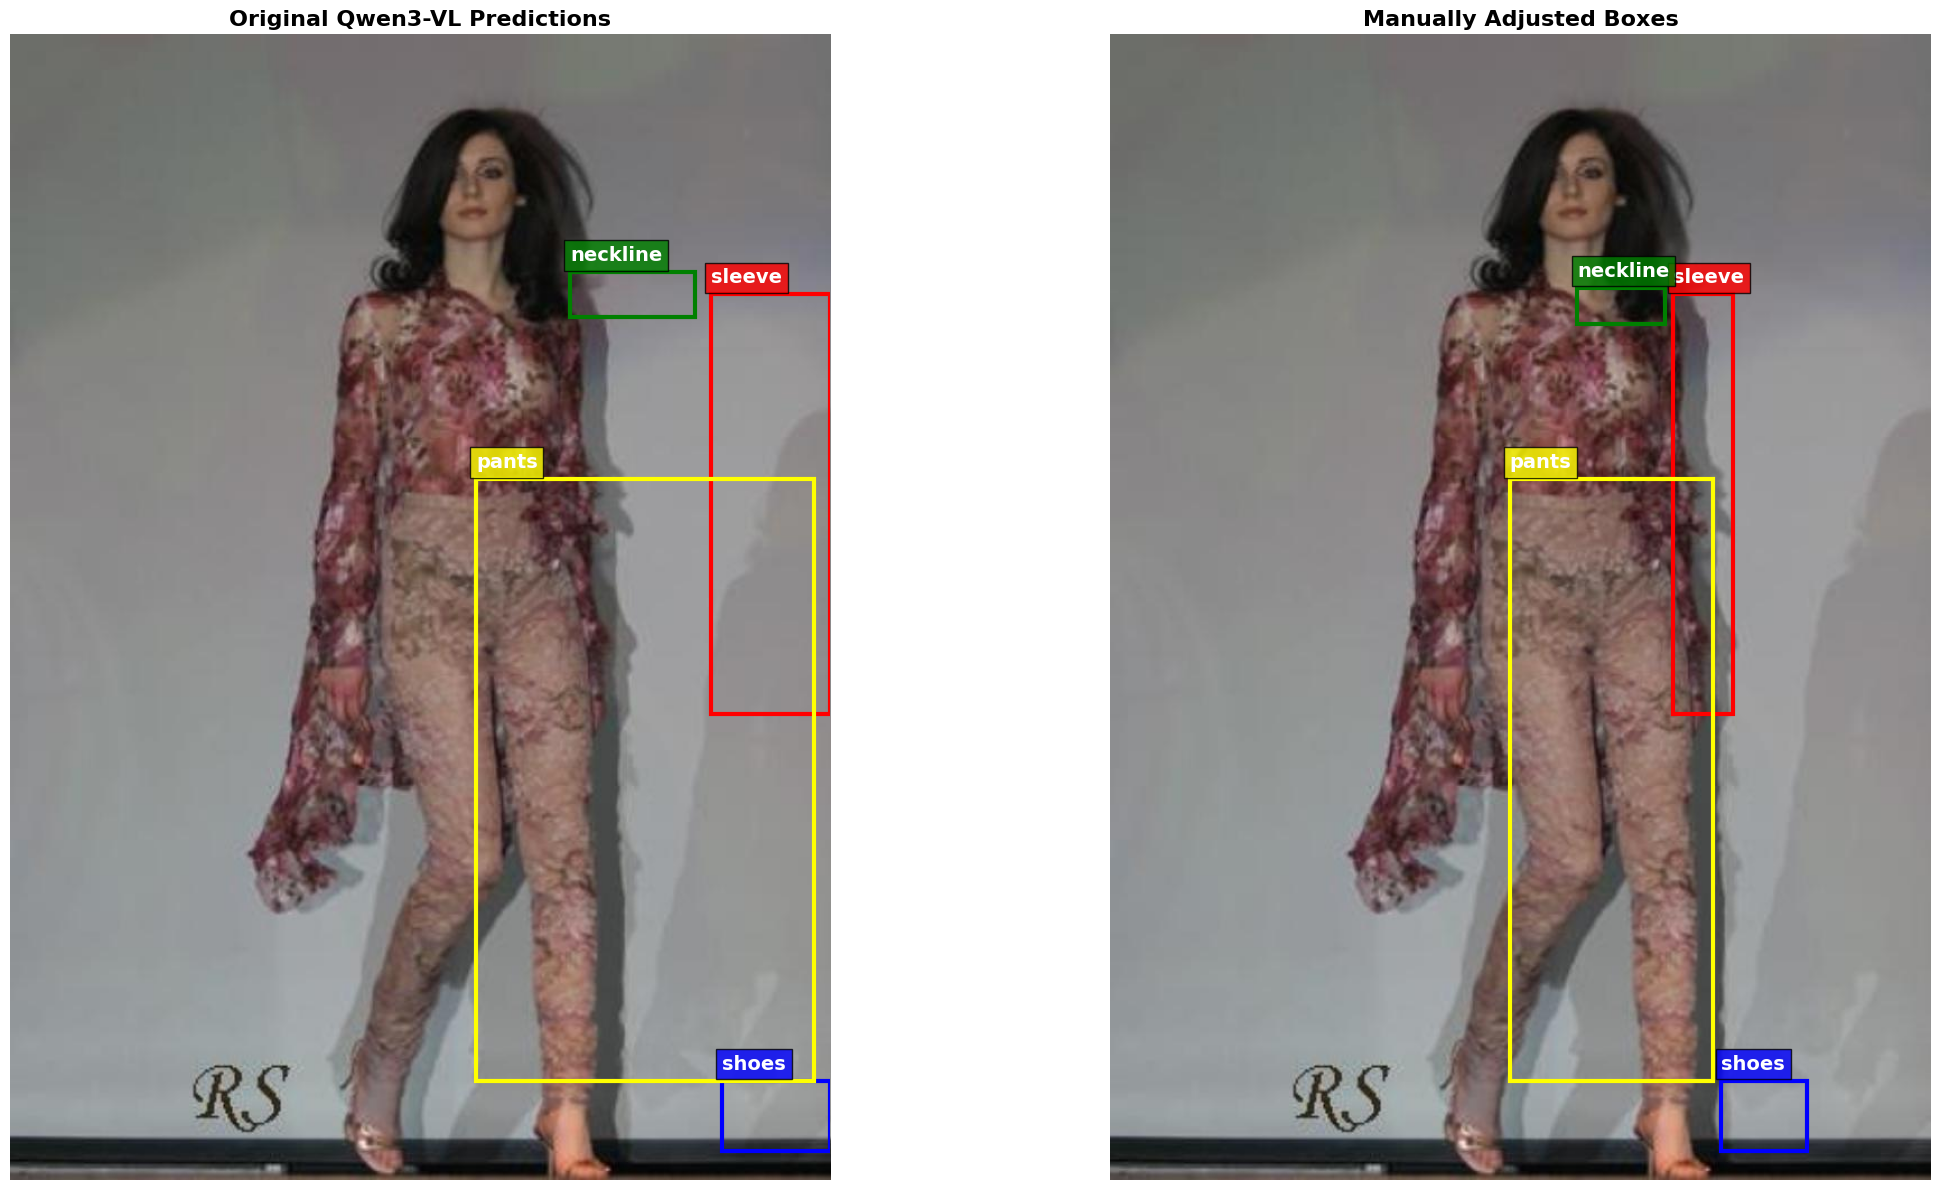


Visualized 4 fashion items (original vs adjusted)


In [16]:
from PIL import Image
import torch
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load your image
image_path = "/orcd/home/002/yuexing/COLM2026/data/train/06119298104c978ec95233ca0d14815a.jpg"
image = Image.open(image_path)
print(f"Image size: {image.size}")

# Create the prompt asking for multiple items
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image,
            },
            {
                "type": "text",
                "text": """Detect the following fashion items in this image and return their bounding box coordinates:
- sleeve
- shoes
- neckline
- pants

For each item found, return in this format:
item_name: [x1, y1, x2, y2]

Only return the coordinates, nothing else."""
            },
        ],
    }
]

# Prepare for the model
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

# Process inputs
inputs = processor(
    text=[text],
    images=[image],
    padding=True,
    return_tensors="pt",
).to(model.device)

# Generate response
print("Generating bounding box predictions for multiple items...")
with torch.no_grad():
    generated_ids = model.generate(
        **inputs,
        max_new_tokens=256,
        do_sample=False
    )

# Decode output
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)[0]

print(f"\nModel output:\n{output_text}")
print("\n" + "="*60)

# Parse all detected items and coordinates
detected_items = {}

# Pattern to match: item_name: [x1, y1, x2, y2] or item_name [x1, y1, x2, y2]
pattern = r'(sleeve|shoes|neckline|pants)[:\s]+\[?\(?([\d.]+),\s*([\d.]+),\s*([\d.]+),\s*([\d.]+)\)?\]?'
matches = re.findall(pattern, output_text.lower())

for match in matches:
    item_name = match[0]
    coords = tuple(map(float, match[1:5]))
    detected_items[item_name] = coords
    print(f"Detected {item_name}: {coords}")

# ============ ADJUSTMENT FUNCTION ============
def adjust_bbox(bbox, x_offset=-100, y_offset=0, scale_x=0.7, scale_y=1.0):
    """
    Adjust bounding box with manual corrections
    
    Args:
        bbox: (x1, y1, x2, y2)
        x_offset: shift left (negative) or right (positive)
        y_offset: shift up (negative) or down (positive)
        scale_x: scale width (< 1 to shrink, > 1 to expand)
        scale_y: scale height
    """
    x1, y1, x2, y2 = bbox
    
    # Calculate center and dimensions
    width = x2 - x1
    height = y2 - y1
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    # Apply offset to center
    new_center_x = center_x + x_offset
    new_center_y = center_y + y_offset
    
    # Apply scaling
    new_width = width * scale_x
    new_height = height * scale_y
    
    # Calculate new corners
    new_x1 = new_center_x - new_width / 2
    new_y1 = new_center_y - new_height / 2
    new_x2 = new_center_x + new_width / 2
    new_y2 = new_center_y + new_height / 2
    
    return (new_x1, new_y1, new_x2, new_y2)

# Define adjustments for each item type
adjustments = {
    'sleeve': {'x_offset': -150, 'y_offset': 0, 'scale_x': 0.5, 'scale_y': 1.0},
    'shoes': {'x_offset': -100, 'y_offset': 0, 'scale_x': 0.8, 'scale_y': 1.0},
    'neckline': {'x_offset': -100, 'y_offset': 10, 'scale_x': 0.7, 'scale_y': 0.8},
    'pants': {'x_offset': -120, 'y_offset': 0, 'scale_x': 0.6, 'scale_y': 1.0},
}

# Apply adjustments
adjusted_items = {}
for item_name, bbox in detected_items.items():
    if item_name in adjustments:
        params = adjustments[item_name]
        adjusted_items[item_name] = adjust_bbox(bbox, **params)
    else:
        adjusted_items[item_name] = bbox

print("\n" + "="*60)
print("Adjusted Bounding Boxes:")
for item_name, coords in adjusted_items.items():
    print(f"{item_name}: {coords}")

# Visualize: Original vs Adjusted
if detected_items:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 12))
    
    colors = {
        'sleeve': 'red',
        'shoes': 'blue',
        'neckline': 'green',
        'pants': 'yellow'
    }
    
    # Original predictions
    ax1.imshow(image)
    ax1.set_title("Original Qwen3-VL Predictions", fontsize=16, weight='bold')
    for item_name, (x1, y1, x2, y2) in detected_items.items():
        color = colors.get(item_name, 'red')
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=3, edgecolor=color, facecolor='none'
        )
        ax1.add_patch(rect)
        ax1.text(x1, y1 - 10, item_name, 
                color='white', fontsize=14, weight='bold',
                bbox=dict(facecolor=color, alpha=0.8))
    ax1.axis('off')
    
    # Adjusted predictions
    ax2.imshow(image)
    ax2.set_title("Manually Adjusted Boxes", fontsize=16, weight='bold')
    for item_name, (x1, y1, x2, y2) in adjusted_items.items():
        color = colors.get(item_name, 'red')
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=3, edgecolor=color, facecolor='none'
        )
        ax2.add_patch(rect)
        ax2.text(x1, y1 - 10, item_name, 
                color='white', fontsize=14, weight='bold',
                bbox=dict(facecolor=color, alpha=0.8))
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nVisualized {len(detected_items)} fashion items (original vs adjusted)")
else:
    print("\nNo items detected with coordinates.")
    print("The model may not have returned numerical coordinates.")